In [1]:
# --- H E R E   B E   I M P O R T S --- #
#!pip install Keras
#!pip install tensorflow
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.data

import nltk
nltk.download('punkt')
from string import digits


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edufre8\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], enable=True)

Num GPUs Available:  0


Data scraping

In [3]:
def killbreaks(string):
    string = string.replace('\n', ' ')
    string = string.replace('\r', ' ')
    return string

In [2]:
def sparknotesScraper(play):
    '''Writes a processed .txt file for the given shakespearean play on SparkNotes.
    
        Argument: play name as spelled on SparkNotes
            ex: 'Romeo and Juliet' is romeojuliet
        
        Return: None
        
        Output: Two text files, play.txt and playCleaned.txt'''
    
    # i is the current page, sparknotes counts them in even numbers
    i=2
    
    print("Reading {0} from https://www.sparknotes.com/nofear/shakespeare/{0}/ ...".format(play))
    
    # makes a text file to which to copy <div> contents
    with open('{0}.txt'.format(play),"w+",encoding="utf-8")  as fp:
        
        # limit set at 500 pages, just to prevent infinite loop
        #    in case break statement not triggered
        while i <= 1000 :
            
            # 200 is the successful access status code. 300 are redirects
            # and above is garbage, non-200 code means the page doesn't
            # exist or is unreachable
            head = requests.head("https://www.sparknotes.com/nofear/shakespeare/{0}/page_{1}/".format(play,i))
            if head.status_code >= 300:
                print("End of visible play reached, {0} is last visible page at i={1}".format(int(i/2),i))
                break
                
            # start reading html content
            # some <div>s contain linebreaks, killbreaks() gets rid of them
            with urllib.request.urlopen("https://www.sparknotes.com/nofear/shakespeare/{0}/page_{1}/".format(play,i)) as page:
                soup = BeautifulSoup(page)
                table = soup.find("table")
                rows = table.findAll("tr")
                for row in rows:
                    for td in row.find_all("td", {"class":"noFear__cell noFear__cell--original"}):
                        for div in td.find_all("div"):
                            fp.write(killbreaks(div.text)+" ")
                        fp.write("\n")
                    for td in row.find_all("td", {"class":"noFear__cell noFear__cell--modern"}):
                        for div in td.find_all("div"):
                            fp.write(killbreaks(div.text)+" ")
                        fp.write("\n\n")
            
            if i%50 == 0:
                print("Reached page {0} at i={1},".format(int(i/2),i))
            
            i+=2
            
        print('\'{0}\' is read.'.format(play))

In [67]:
sparknotesScraper('hamlet')
sparknotesScraper('macbeth')
sparknotesScraper('romeojuliet')

Reading hamlet from https://www.sparknotes.com/nofear/shakespeare/hamlet/ ...
Reached page 25 at i=50,
Reached page 50 at i=100,
Reached page 75 at i=150,
Reached page 100 at i=200,
Reached page 125 at i=250,
Reached page 150 at i=300,
End of visible play reached, 169 is last visible page at i=338
'hamlet' is read.
Reading macbeth from https://www.sparknotes.com/nofear/shakespeare/macbeth/ ...
Reached page 25 at i=50,
Reached page 50 at i=100,
Reached page 75 at i=150,
Reached page 100 at i=200,
End of visible play reached, 110 is last visible page at i=220
'macbeth' is read.
Reading romeojuliet from https://www.sparknotes.com/nofear/shakespeare/romeojuliet/ ...
Reached page 25 at i=50,
Reached page 50 at i=100,
Reached page 75 at i=150,
Reached page 100 at i=200,
Reached page 125 at i=250,
End of visible play reached, 144 is last visible page at i=288
'romeojuliet' is read.


In [5]:
sparknotesScraper('lear')
sparknotesScraper('juliuscaesar')
sparknotesScraper('henry4pt1')
sparknotesScraper('henry4pt2')
sparknotesScraper('henryv')
sparknotesScraper('coriolanus')
sparknotesScraper('asyoulikeit')
sparknotesScraper('antony-and-cleopatra')
sparknotesScraper('measure-for-measure')
sparknotesScraper('errors')
sparknotesScraper('merchant')
sparknotesScraper('msnd')
sparknotesScraper('othello')

Reading lear from https://www.sparknotes.com/nofear/shakespeare/lear/ ...
Reached page 25 at i=50,
Reached page 50 at i=100,
Reached page 75 at i=150,
Reached page 100 at i=200,
Reached page 125 at i=250,
Reached page 150 at i=300,
End of visible play reached, 156 is last visible page at i=312
'lear' is read.
Reading juliuscaesar from https://www.sparknotes.com/nofear/shakespeare/juliuscaesar/ ...
Reached page 25 at i=50,
Reached page 50 at i=100,


KeyboardInterrupt: 

In [6]:
# to add : henry4pt1 and henry4pt2 (odd indices)
filenames = ['hamlet.txt', 'romeojuliet.txt', 'lear.txt', 'juliuscaesar.txt', 'henryv.txt', 'coriolanus.txt', 'errors.txt', 'asyoulikeit.txt','antony-and-cleopatra.txt', 'measure-for-measure.txt', 'merchant.txt', 'msnd.txt', 'othello.txt']
with open('trainingSet.txt', 'w', encoding="utf-8") as outfile:
    for fname in filenames:
        with open(fname, encoding="utf-8") as infile:
            for line in infile:
                outfile.write(line)

FileNotFoundError: [Errno 2] No such file or directory: 'hamlet.txt'

Dataset pairing and cleaning

In [11]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [2]:
def load_document(filename):
    #open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    #store in variable  
    text=file.read()
    #close it
    file.close
    return text

In [3]:
def make_pairs(document):
    #group the corresponding lines
    to_be_paired = document.split('\n\n')
    #pair the corresponding translations
    line_pairs = [line.split('\n') for line in to_be_paired]
    #pair the corresponding sentences
    #sentece_pairs = [line.split('.') for line in  lines]
    return line_pairs

In [4]:
#---dataset cleaning------
def clean(pairs, num_sentences):
    if num_sentences == 'all':
        num_sentences = len(pairs)-1
    cleaned= []
    # regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    for pair in pairs[:num_sentences]:
        clean_pair = [] 
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [re_print.sub('', word) for word in line]
            # remove tokens with numbers in them
            line = [word.translate(str.maketrans('', '', digits)) for word in line]
            # add space before punctuation
            line = [re.sub('([.,!?()])', r' \1 ', word) for word in line]
            #remove extra spaces
            line = [re.sub(' +', ' ', word) for word in line]
            # store as string
            clean_pair.append(' '.join(line))
        # keep only pairs of 2
        if len(clean_pair) == 2:
            # split into sentences instead of lines
            if len(nltk.tokenize.sent_tokenize(clean_pair[0])) > 1 :
                first = nltk.tokenize.sent_tokenize(clean_pair[0])
                second = nltk.tokenize.sent_tokenize(clean_pair[1])
                # add a start and an end token to the sentences
                first = ['<start> ' + sentence + ' <end>' for sentence in first]
                second = ['<start> ' + sentence + ' <end>' for sentence in second]
                length = min(len(first), len(second))
                i=0
                while i < length :
                # keep only short sentences and verify the lengths are about the same
                    if len(first[i]) < 115 and (2.5*len(first[i]) > len(second[i]) or 2.5*len(first[i]) > len(second[i])):
                         cleaned.append([first[i],second[i]])
                    i+=1
            else :
                # keep only short sentences
                if len(clean_pair[0]) < 100 :
                    # add a start and an end token to the sentences
                    clean_pair = ['<start> ' + sentence + ' <end>' for sentence in clean_pair]
                    cleaned.append(clean_pair)
    print(cleaned)
    return zip(*cleaned)

In [5]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [6]:
# tokenize the sentences
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    return tensor, lang_tokenizer

In [7]:
# convert to vector
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [8]:
def load_dataset(path, num_sentences):#=None):
    # load dataset
    doc = load_document(path)
    # split into pairs
    pairs = make_pairs(doc)
    # clean sentences
    cleaned_pairs = clean(pairs, num_sentences) #cleaned_pairs[0] : shakespearean English
                                                #cleaned_pairs[1] : modern English 
    # save clean pairs to file  
    save_clean_data(cleaned_pairs, 'translation-clean.pkl')
    
    # associating sentences to their respective language 
    targ_lang, inp_lang = cleaned_pairs
    
    # creating cleaned input, output pairs
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

Methods testing

In [9]:
# Try experimenting with the size of that dataset
num_examples = 'all'
#print(load_dataset('trainingSet.txt', num_examples))
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset('trainingSet.txt', num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

# Creating training and vhttp://localhost:8888/notebooks/Desktop/WINTER%202021/MAIS%20202/translator/Untitled.ipynb#alidation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

[['<start> enter barnardo and francisco ,  two sentinels <end>', '<start> barnardo and francisco ,  two watchmen ,  enter .  <end>'], ['<start> whos there ?  <end>', '<start> whos there ?  <end>'], ['<start> nay ,  answer me . <end>', '<start> no ,  who are you ? <end>'], ['<start> stand and unfold yourself . <end>', '<start> stop and identify yourself . <end>'], ['<start> long live the king !  <end>', '<start> long live the king !  <end>'], ['<start> barnardo ?  <end>', '<start> is that barnardo ?  <end>'], ['<start> he .  <end>', '<start> yes ,  its me .  <end>'], ['<start> you come most carefully upon your hour .  <end>', '<start> youve come right on time .  <end>'], ["<start> 'tis now struck twelve . <end>", '<start> the clocks just striking twelve . <end>'], ['<start> get thee to bed ,  francisco . <end>', '<start> go home to bed ,  francisco . <end>'], ['<start> for this relief much thanks . <end>', '<start> thanks for letting me go . <end>'], ["<start> 'tis bitter cold ,  and i 

18554 18554 4639 4639


In [ ]:
load_dataset('trainingSet.txt', 'all')
print ("Modern English; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Shakespearean English; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Create tf.data dataset

In [21]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 63]), TensorShape([64, 10]))

In [22]:
# load dataset
#doc = load_document('hamlet.txt')
# split into pairs
#pairs = make_pairs(doc)
# clean sentences
#cleaned_pairs = clean(pairs)
# save clean pairs to file
#save_clean_data(cleaned_pairs, 'translation-clean.pkl')
#cleaned_pairs[0] : shakespearean English
#cleaned_pairs[1] : modern English
#print(cleaned_pairs)

# spot check
#for i in range(10):
#	print('[%s] => [%s]' % (cleaned_pairs[i][0], cleaned_pairs[i][1]))

Encoding

In [23]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [24]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 63, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


Attention Layer

In [25]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [26]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 63, 1)


Decoder

In [27]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size, vocab)
        x = self.fc(output)
        return x, state, attention_weights

In [28]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2300)


Optimization and Loss Function

In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)

Training

In [31]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [32]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 3.1447
Epoch 1 Loss 2.3626
Time taken for 1 epoch 134.5565207004547 sec

Epoch 2 Batch 0 Loss 1.9685
Epoch 2 Loss 1.9721
Time taken for 1 epoch 121.98211622238159 sec

Epoch 3 Batch 0 Loss 1.7585
Epoch 3 Loss 1.8430
Time taken for 1 epoch 123.1156554222107 sec

Epoch 4 Batch 0 Loss 1.7383
Epoch 4 Loss 1.7225
Time taken for 1 epoch 121.56778740882874 sec

Epoch 5 Batch 0 Loss 1.6558
Epoch 5 Loss 1.5952
Time taken for 1 epoch 117.85222816467285 sec

Epoch 6 Batch 0 Loss 1.3722
Epoch 6 Loss 1.4761
Time taken for 1 epoch 117.39687466621399 sec

Epoch 7 Batch 0 Loss 1.3355
Epoch 7 Loss 1.3560
Time taken for 1 epoch 119.43878483772278 sec

Epoch 8 Batch 0 Loss 1.0981
Epoch 8 Loss 1.2321
Time taken for 1 epoch 118.4023368358612 sec

Epoch 9 Batch 0 Loss 1.0501
Epoch 9 Loss 1.1001
Time taken for 1 epoch 115.28801274299622 sec

Epoch 10 Batch 0 Loss 1.0961
Epoch 10 Loss 0.9755
Time taken for 1 epoch 119.10079169273376 sec



Translation

In [33]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden, enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
        return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [34]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [35]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> it all the same if there s any good deed i can do that will bring you peace and me honor speak to me <end>
Predicted translation: i 


<ipython-input-34-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-34-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


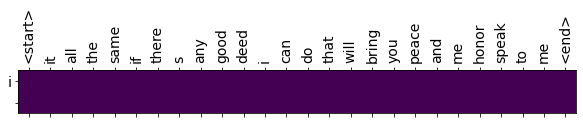

In [40]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

translate(u'It’ all the same If there’s any good deed I can do that will bring you peace and me honor speak to me')